<br>

# Clustering Algorithms
---

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width=800 height=700></img>

<br>

## Cluster a set of documents by Topic / Theme using Python. 
---

Our motivation is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list)

We will attempt to cover

- Tokenizing and stemming
- Transforming the corpus into **vector space** using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- Calculating cosine distance between each document as a measure of similarity
- Clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
- Using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
- pPlotting the clustering output using [matplotlib](http://matplotlib.org/) 
- Conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
- Plotting a Ward dendrogram
- Topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

<br>

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [2]:
with open('../data/synopses_list_imdb.txt', 'r') as f:
    synopses = f.read()

with open('../data/title_list.txt', 'r') as f:
    titles = f.read().split('\n')

In [3]:
with open('../data/genres_list.txt', 'r') as f:
    genres = f.read().split('\n')

In [4]:
dict_movies_and_synopsis = {
    title: text.replace("\n", '').strip() 
    for title,text 
    in zip(titles, synopses.split("BREAKS HERE"))
}

In [5]:
pd.Series(dict_movies_and_synopsis, name='Synopsis').to_frame()

,Synopsis
The Godfather,"In late summer 1945, guests are gathered for t..."
The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
Schindler's List,The relocation of Polish Jews from surrounding...
Raging Bull,"The film opens in 1964, where an older and fat..."
Casablanca,"In the early years of World War II, December 1..."
...,...
Rear Window,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
The Third Man,"Sights of Vienna, Austria, flash across the sc..."
North by Northwest,"At the end of an ordinary work day, advertisin..."
Yankee Doodle Dandy,


---
## Stopwords

- First, load [NLTK's](http://www.nltk.org/) list of English stop words. 
- [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning

<br>

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('stopwords', )

[nltk_data] Downloading package stopwords to /Users/dush/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# load nltk's English stopwords as variable called 'stopwords'

stopwords = nltk.corpus.stopwords.words('english')

In [8]:
print(stopwords[:10])

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


---

## Stemming

- Import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK
- [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root

Below I define two functions:


- *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token 
- *tokenize_only*: tokenizes the synopsis only

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!

<br>


In [9]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [10]:
def tokenize_only(text):
    """
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [11]:
def tokenize_and_stem(text):
    """
    """
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [12]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/dush/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
print(tokenize_only("Tessio is driven away and never seen again (it is implied that Cicci shoots and kills Tessio with his own gun after he disarms him prior to entering the car)"))

['tessio', 'is', 'driven', 'away', 'and', 'never', 'seen', 'again', 'it', 'is', 'implied', 'that', 'cicci', 'shoots', 'and', 'kills', 'tessio', 'with', 'his', 'own', 'gun', 'after', 'he', 'disarms', 'him', 'prior', 'to', 'entering', 'the', 'car']


In [14]:
print(tokenize_and_stem("Tessio is driven away and never seen again (it is implied that Cicci shoots and kills Tessio with his own gun after he disarms him prior to entering the car)"))

['tessio', 'is', 'driven', 'away', 'and', 'never', 'seen', 'again', 'it', 'is', 'impli', 'that', 'cicci', 'shoot', 'and', 'kill', 'tessio', 'with', 'his', 'own', 'gun', 'after', 'he', 'disarm', 'him', 'prior', 'to', 'enter', 'the', 'car']


In [15]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in dict_movies_and_synopsis.values():
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

<br>

Using these two lists, I create a pandas DataFrame 
- with the stemmed vocabulary as the index and 
- the tokenized words as the column. 

The benefit of this is it provides an efficient way to look up a stem and return a full token. 

The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. 
For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

<br>

In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [17]:
vocab_frame.shape

(147591, 1)

In [18]:
vocab_frame.sample(10)

,words
ecstat,ecstatic
room,room
are,are
vito,vito
mani,many
run,run
has,has
off,off
that,that
he,he


## Tf-idf and Document Similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

- Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

- To get a Tf-idf matrix, first count word occurrences by document. 
    - This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

- Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

- `max_df`: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
- `min_idf`: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
- `ngram_range`: this just means I'll look at unigrams, bigrams and trigrams. 
    - See [n-grams](http://en.wikipedia.org/wiki/N-gram)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

#fit the vectorizer to synopses
tfidf_matrix = tfidf_vectorizer.fit_transform(dict_movies_and_synopsis.values()) 

print(tfidf_matrix.shape)

/Users/dush/Code/cst4150/.fintech/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dush/Code/cst4150/.fintech/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor',

(101, 347)


*terms* is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [20]:
terms = tfidf_vectorizer.get_feature_names_out()

In [21]:
terms[:20]

array(["'d", 'abl', 'accept', 'accompani', 'act', 'admit', 'afterward',
       'agre', 'aliv', 'allow', 'alon', 'alreadi', 'alway', 'american',
       'ani', 'anoth', 'anyth', 'apart', 'appar', 'appear'], dtype=object)

<br>

### Cosine Similarity

---

- Distance `dist` is defined as `1 - cosine similarity` of each document. 
- Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses)
- Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
- Note that with *dist* it is possible to evaluate the similarity of any two or more synopses.

<br>

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [23]:
import seaborn as sns

<Axes: >

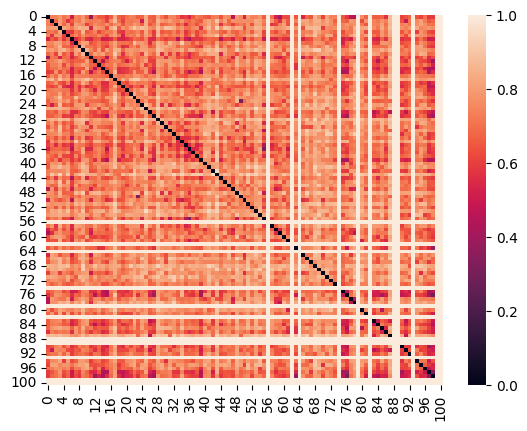

In [24]:
sns.heatmap(pd.DataFrame(dist))

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [25]:
from sklearn.cluster import KMeans
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].

I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of [Pandas](http://pandas.pydata.org/) and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [26]:
pd.DataFrame(data={'Title':list(dict_movies_and_synopsis.keys()), 
                   'Syn': list(dict_movies_and_synopsis.values()), 
                   'Clus':clusters
                  }).sort_values('Clus').groupby("Clus").head(2)

,Title,Syn,Clus
100,,,0
90,The Maltese Falcon,Private eye Sam Spade and his partner Miles Ar...,0
24,The Bridge on the River Kwai,[this synopsis is primarily from the wikipedia...,1
55,Platoon,Chris Taylor (Charlie Sheen) is a young Americ...,1
3,Raging Bull,"The film opens in 1964, where an older and fat...",2
91,A Clockwork Orange,"""A bit of the old ultra-violence"".London, Engl...",2
50,Braveheart,"In the 13th Century England, after several yea...",3
68,Midnight Cowboy,Joe Buck (Jon Voight) leaves his job as a dish...,3
11,The Godfather: Part II,The Godfather Part II presents two parallel st...,4
41,The Philadelphia Story,Tracy Samantha Lord Haven (Katharine Hepburn) ...,4


In [137]:
grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    36.117647
1    64.695652
2    47.729730
3    45.000000
4    59.700000
Name: rank, dtype: float64

Note that **clusters 4 and 0** have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.


Here is some fancy indexing and sorting on each cluster to identify which are the top *n* (I chose *n*=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [140]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order_centroids

array([[ 75, 312,  26, ..., 230, 361,  82],
       [205, 223, 206, ..., 260, 199,  67],
       [331, 225,  60, ...,  26,  66, 328],
       [124, 314, 354, ..., 223, 234, 141],
       [125,  54,  90, ...,  25, 164,   0]])

In [145]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'commanding', b'soldiers', b'army', b'killed', b'men', b'orders',

Cluster 0 titles: Schindler's List, Casablanca, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, The Best Years of Our Lives, Patton, The Good, the Bad and the Ugly, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Deer Hunter,

Cluster 1 words: b'love', b'mr.', b'make', b'john', b'come', b'living',

Cluster 1 titles: Citizen Kane, The Sound of Music, Singin' in the Rain, The Philadelphia Story, An American in Paris, My Fair Lady, The Apartment, High Noon, All Quiet on the Western Front, City Lights, Midnight Cowboy, Mr. Smith Goes to Washington, Annie Hall, Out of Africa, Terms of Endearment, Shane, The Green Mile, Network, The African Queen, Stagecoach, Mutiny on the Bounty, Wuthering Heights, Y

# Multidimensional scaling

Here is some code to convert the dist matrix into a 2-dimensional array using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling). I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use [principal component analysis](http://en.wikipedia.org/wiki/Principal_component_analysis). 

In [146]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Visualizing document clusters

In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js). 

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [147]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

AttributeError: 'DataFrame' object has no attribute 'ix'

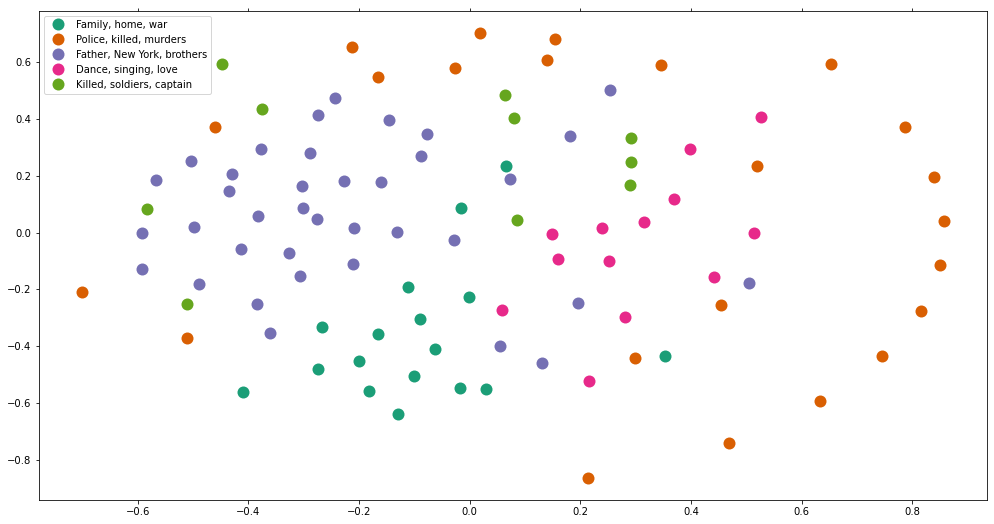

In [148]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [149]:
plt.close()

# Hierarchical document clustering

Now that I was successfuly able to cluster and plot the documents using k-means, I wanted to try another clustering algorithm. I chose the [Ward clustering algorithm](http://en.wikipedia.org/wiki/Ward%27s_method) because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. I used the precomputed cosine distance matrix (*dist*) to calclate a linkage_matrix, which I then plot as a dendrogram. 

Note that this method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. Note that the cluster in red contains many of the "Killed, soldiers, captain" films. *Braveheart* and *Gladiator* are within the same low-level cluster which is interesting as these are probably my two favorite movies.

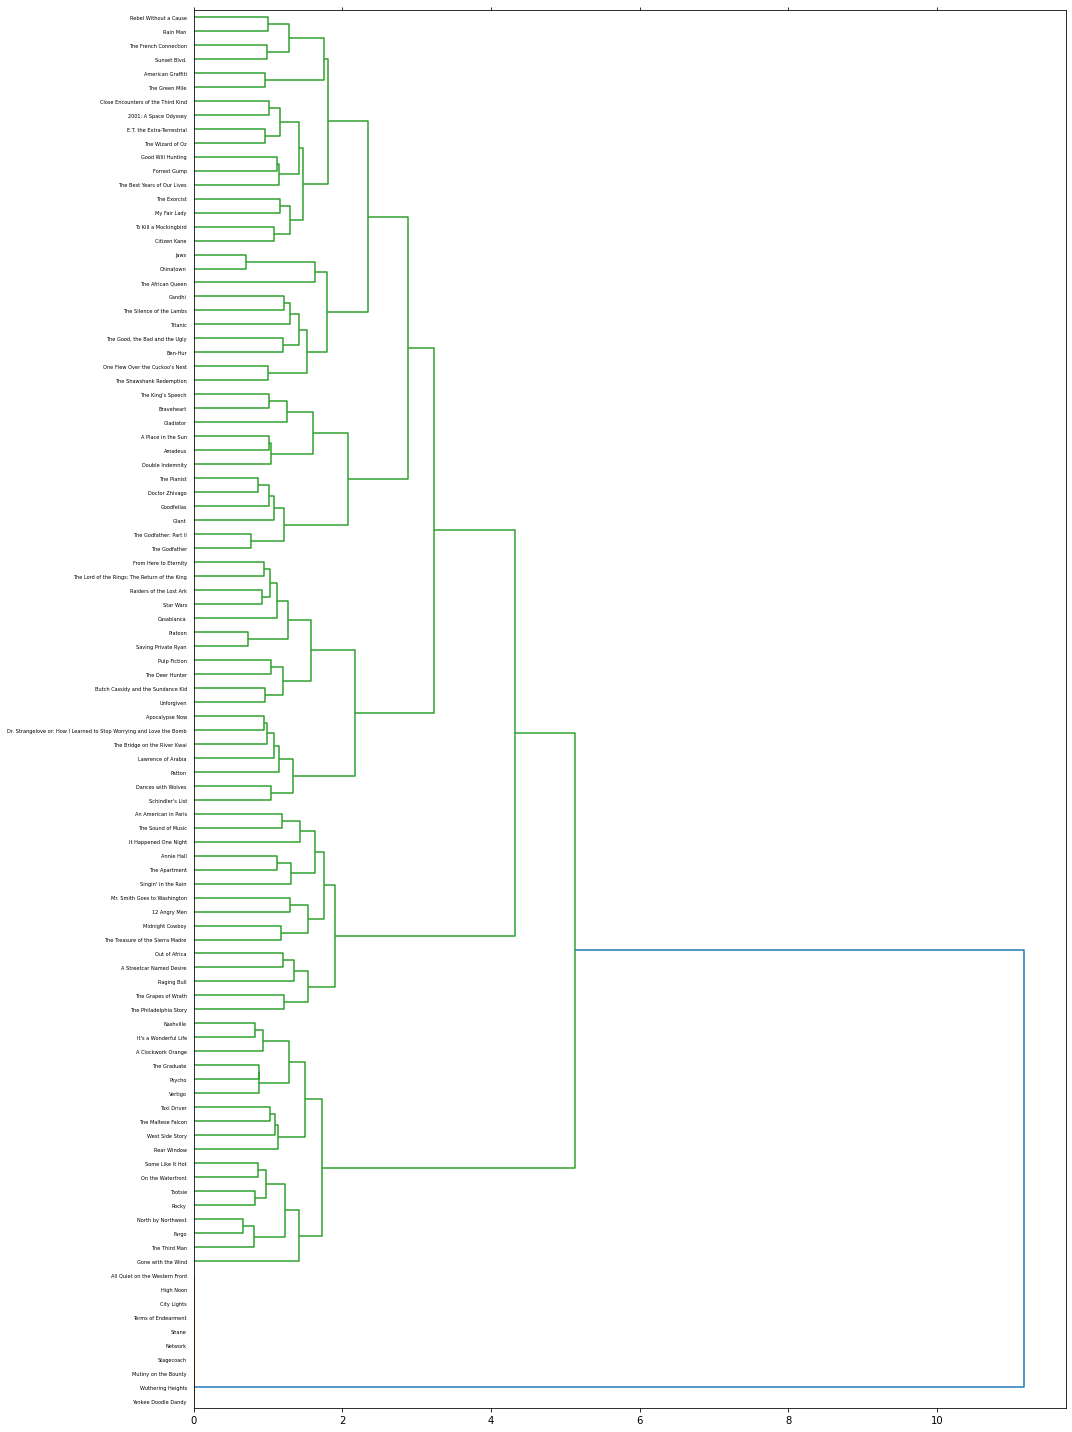

In [150]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
plt.close()

<p> </p></br>

# Latent Dirichlet Allocation

This section focuses on using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the [Communications of the ACM here](http://delivery.acm.org/10.1145/2140000/2133826/p77-blei.pdf?ip=68.48.185.120&id=2133826&acc=OPEN&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E6D218144511F3437&CFID=612398453&CFTOKEN=48760790&__acm__=1419436704_2d47aefe0700e44f81eb822df659a341). Incidentally, Blei was one of the authors of the seminal paper on LDA.

For my implementaiton of LDA, I use the [Gensim pacakage](https://radimrehurek.com/gensim/). I'm going to preprocess the synopses a bit differently here, and first I define a function to remove any proper noun.

In [ ]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

Since the above function is just based on capitalization, it is prone to remove words at the beginning of sentences. So, I wrote the below function using NLTK's part of speech tagger. However, it took way too long to run across all synopses, so I stuck with the above.

In [ ]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [ ]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

Below are some Gensim specific conversions; I also filter out extreme words (see inline comment)

In [ ]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

The actual model runs below. I took 100 passes to ensure convergence, but you can see that it took my machine 13 minutes to run. My chunksize is larger than the corpus so basically all synopses are used per pass. I should optimize this, and Gensim has the capacity to run in parallel. I'll likely explore this further as I use the implementation on larger corpora.

In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)

Each topic has a set of words that defines it, along with a certain probability.

In [ ]:
lda.show_topics()

Here, I convert the topics into just a list of the top 20 words in each topic. You can see a similar breakdown of topics as I identified using k-means including a war/family topic and a more clearly war/epic topic.

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()